<a href="https://www.kaggle.com/code/tusharkhare06/project-1-restaurant-recommendation-system-indore?scriptVersionId=230715332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-recommendation-system-indore/zomato_indore.xlsx


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_excel("/kaggle/input/restaurant-recommendation-system-indore/zomato_indore.xlsx")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2851 non-null   int64  
 1   Name              2851 non-null   object 
 2   Locality          2851 non-null   object 
 3   Cuisines          2851 non-null   object 
 4   avg_cost_for_two  2851 non-null   int64  
 5   aggregate_rating  2851 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 133.8+ KB


In [5]:
print(df[['Name', 'aggregate_rating']].drop_duplicates().shape)


(903, 2)


In [6]:
print(df['aggregate_rating'].value_counts().head(20))  # Show top 20 most common ratings


aggregate_rating
4.1    307
3.9    284
4.3    259
4.0    238
4.4    208
4.2    197
3.8    185
3.7    164
3.6    104
3.3     98
3.5     91
4.6     89
4.5     86
3.2     72
3.4     66
2.8     61
3.0     54
3.1     50
4.7     44
2.7     43
Name: count, dtype: int64


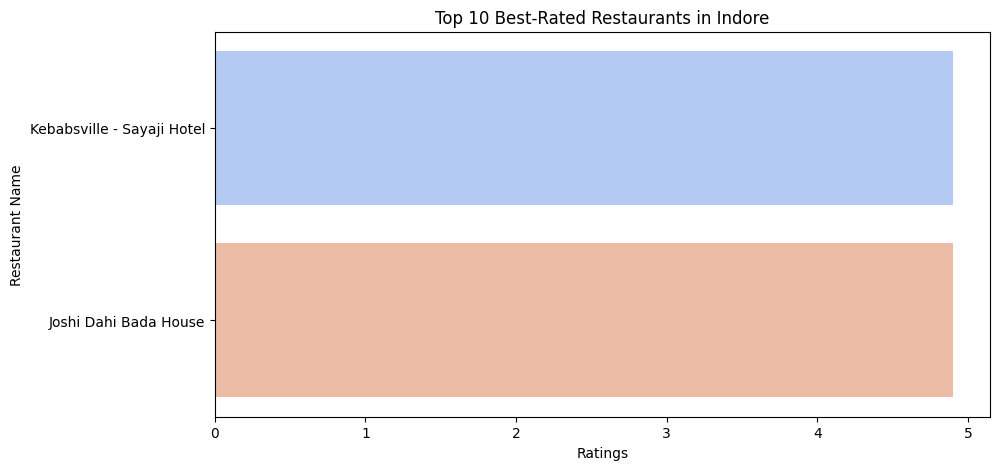

In [7]:
top_10 = df[['Name', 'aggregate_rating']].sort_values(by='aggregate_rating', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x='aggregate_rating', y='Name', data=top_10, palette="coolwarm")
plt.xlabel("Ratings")
plt.ylabel("Restaurant Name")
plt.title("Top 10 Best-Rated Restaurants in Indore")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


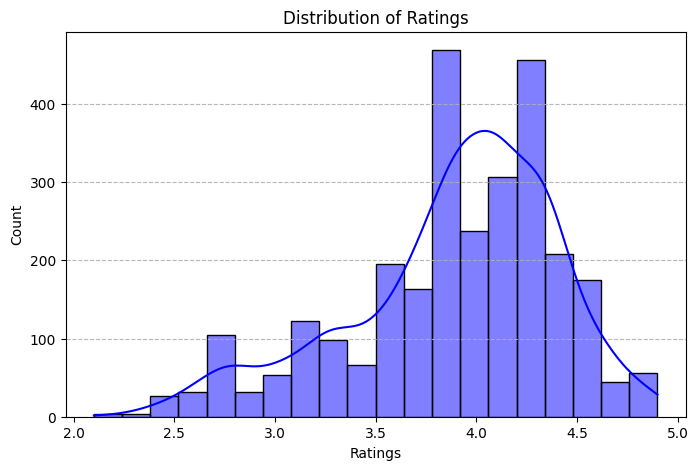

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df['aggregate_rating'], bins=20, kde=True, color='blue')
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()


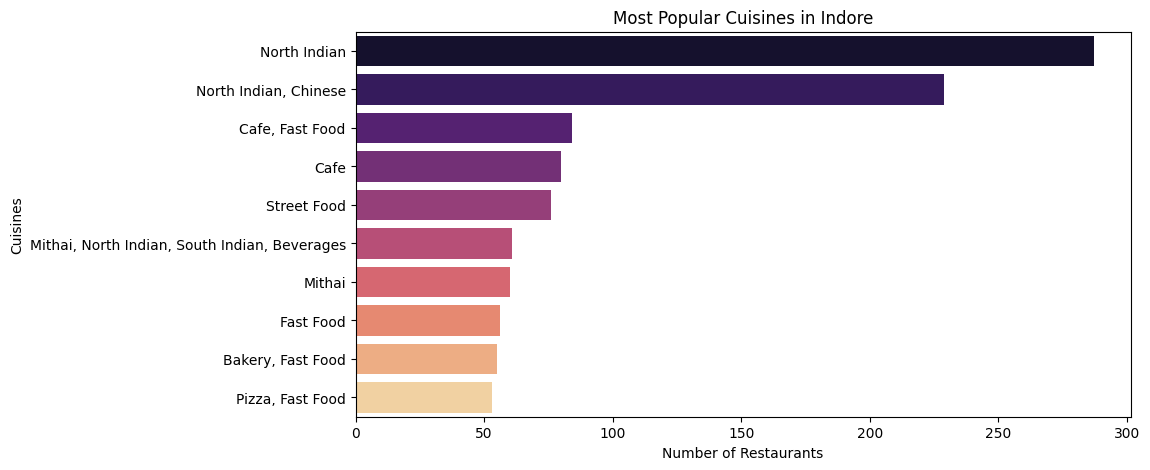

In [9]:
plt.figure(figsize=(10,5))
top_cuisines = df['Cuisines'].value_counts().head(10)

sns.barplot(x=top_cuisines.values, y=top_cuisines.index, palette="magma")
plt.xlabel("Number of Restaurants")
plt.ylabel("Cuisines")
plt.title("Most Popular Cuisines in Indore")
plt.show()


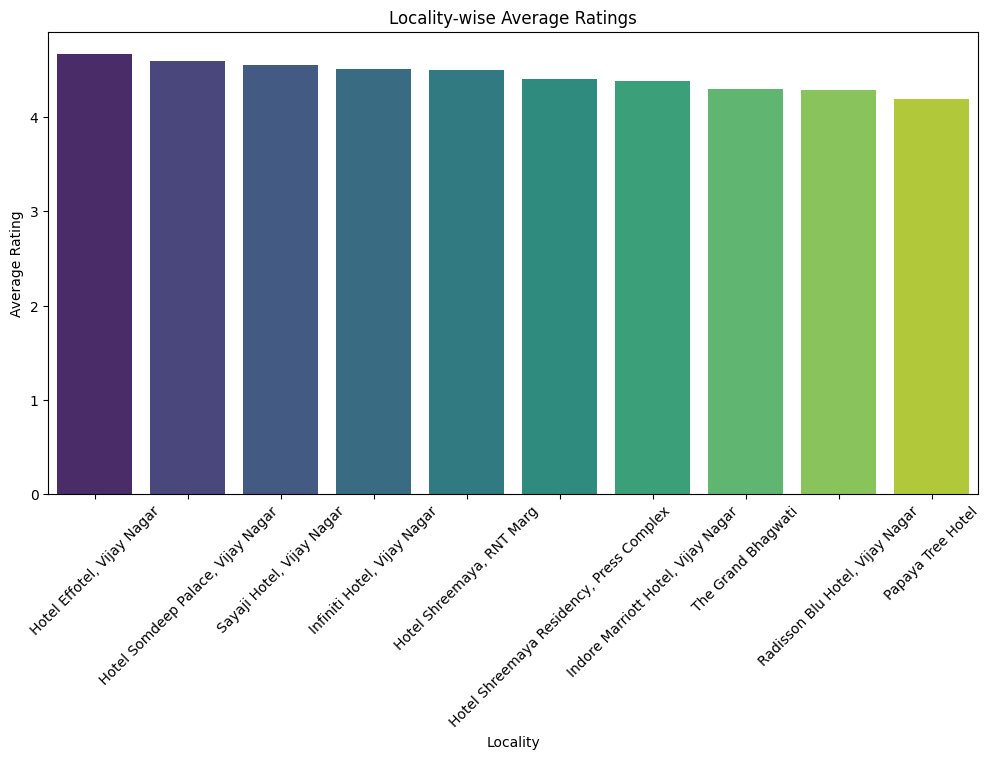

In [10]:
plt.figure(figsize=(12,6))
avg_ratings = df.groupby("Locality")["aggregate_rating"].mean().sort_values(ascending=False).head(10)

sns.barplot(x=avg_ratings.index, y=avg_ratings.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Locality")
plt.ylabel("Average Rating")
plt.title("Locality-wise Average Ratings")
plt.show()

In [11]:
df = df[['Locality', 'Cuisines', 'aggregate_rating', 'Name']]  # Keep only relevant columns  
df.dropna(inplace=True)  # Remove missing values  

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = ohe.fit_transform(df[['Locality', 'Cuisines']])

# Convert the encoded data into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(['Locality', 'Cuisines']))

# Combine the encoded features with Rating & Restaurant Name
df_ml = pd.concat([encoded_df, df[['aggregate_rating', 'Name']]], axis=1)


In [13]:
X = df_ml.drop(columns=['aggregate_rating', 'Name'])  # Features  
y = df_ml['aggregate_rating']  # Target (Rating)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
knn = KNeighborsRegressor(n_neighbors=5)  # Using K=5  
knn.fit(X_train, y_train)  # Train the model  

KNeighborsRegressor()

In [15]:
def predict_best_restaurant(locality, cuisines):
    # Encode input locality & cuisines
    input_data = ohe.transform([[locality, cuisines]])
    input_df = pd.DataFrame(input_data, columns=ohe.get_feature_names_out(['Locality', 'Cuisines']))
    
    # Predict the rating
    predicted_rating = knn.predict(input_df)[0]  # Ensure it returns a single value

    # Find the best restaurant
    filtered_df = df[(df['Locality'] == locality) & (df['Cuisines'].str.contains(cuisines, case=False, na=False))]

    if filtered_df.empty:
        return "No matching restaurant found", None

    best_restaurant = filtered_df.sort_values(by='aggregate_rating', ascending=False).iloc[0]['Name']
    
    return best_restaurant, predicted_rating  # ✅ Ensure two values are returned


In [16]:
if not hasattr(knn, "predict"):
    print("❌ Error: Model not trained yet!")
else:
    print("✅ Model is ready for prediction.")


✅ Model is ready for prediction.


In [17]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Evaluation:")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

📊 Model Evaluation:
🔹 Mean Squared Error (MSE): 0.1485
🔹 R² Score: 0.4952


In [18]:
locality = "Old Palasia"
cuisines = "Chinese"

restaurant, rating = predict_best_restaurant(locality, cuisines)
print(f"🍽️ Best Restaurant in {locality} for {cuisines}: {restaurant} with predicted rating ⭐ {rating}")

🍽️ Best Restaurant in Old Palasia for Chinese: Shree Gautam Chinese with predicted rating ⭐ 3.8600000000000003


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [19]:
import pickle

# Train OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = ohe.fit_transform(df[['Locality', 'Cuisines']])

# Train KNN Model
X = encoded_features  # Use encoded features as input
y = df['aggregate_rating']  # Target variable
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)

# Save OHE and Model Together
with open("restaurant_recommender.pkl", "wb") as file:
    pickle.dump({"ohe": ohe, "model": knn}, file)

print("✅ OHE and KNN model saved successfully as 'restaurant_recommender.pkl'")


✅ OHE and KNN model saved successfully as 'restaurant_recommender.pkl'
